In [2]:
using GLM
using CSV
using Random
using StatsBase
using DataFrames
using Dagitty
using Turing
using StatsPlots
using StatisticalRethinking
using StatisticalRethinkingPlots
using Logging

default(labels=false)
Logging.disable_logging(Logging.Warn);

# 7.1 The problem with parameters

Code 7.1

In [3]:
sppnames = ["afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster", "sapiens"]
brainvolcc = [438, 452, 612, 521, 752, 871, 1350]
masskg = [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]
d = DataFrame(:species => sppnames, :brain => brainvolcc, :mass => masskg);

Code 7.2

In [4]:
d[!,:mass_std] = (d.mass .- mean(d.mass))./std(d.mass)
d[!,:brain_std] = d.brain ./ maximum(d.brain);

Code 7.3

In [37]:
Random.seed!(1)

@model function model_m7_1(mass_std, brain_std)
    a ~ Normal(0.5, 1)
    b ~ Normal(0, 10)
    μ = @. a + b*mass_std
    log_σ ~ Normal()
    brain_std ~ MvNormal(μ, exp(log_σ))
end

m7_1_ch = sample(model_m7_1(d.mass_std, d.brain_std), NUTS(), 1000)
m7_1 = DataFrame(m7_1_ch)
precis(m7_1)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│     a │  0.5287  0.1153   0.3604   0.5264   0.7027   ▁▁▁▁▂▆█▃▁▁▁▁▁ │
│     b │  0.1712    0.16   -0.035   0.1683   0.3598  ▁▁▁▁▁▁█▆▁▁▁▁▁▁ │
│ log_σ │ -1.3836  0.4091  -1.9351  -1.4179  -0.6924         ▁██▃▁▁▁ │
└───────┴────────────────────────────────────────────────────────────┘


Code 7.4

In [38]:
X = hcat(ones(length(d.mass_std)), d.mass_std)
m = lm(X, d.brain_std)

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}:

Coefficients:
───────────────────────────────────────────────────────────────
       Coef.  Std. Error     t  Pr(>|t|)   Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────
x1  0.528677   0.0705692  7.49    0.0007   0.347273    0.710081
x2  0.167118   0.0762235  2.19    0.0798  -0.0288204   0.363057
───────────────────────────────────────────────────────────────


Code 7.5

In [39]:
Random.seed!(12)

# do explicit simulation due to log_σ
s = [
    rand(MvNormal((@. r.a + r.b * d.mass_std), exp(r.log_σ)))
    for r ∈ eachrow(m7_1)
]
s = vcat(s'...);

r = mean.(eachcol(s)) .- d.brain_std;
resid_var = var(r, corrected=false)
outcome_var = var(d.brain_std, corrected=false)
1 - resid_var/outcome_var

0.48411985231935006

Code 7.6

In [40]:
function R2_is_bad(df)
    s = [
        rand(MvNormal((@. r.a + r.b * d.mass_std), exp(r.log_σ)))
        for r ∈ eachrow(df)
    ]
    s = vcat(s'...);

    r = mean.(eachcol(s)) .- d.brain_std;
    1 - var(r, corrected=false) / var(d.brain_std, corrected=false)
end

R2_is_bad (generic function with 1 method)

Code 7.7

In [95]:
Random.seed!(1)

@model function model_m7_2(mass_std, brain_std)
    a ~ Normal(0.5, 1)
    b ~ MvNormal([0, 0], 10)
    μ = @. a + b[1]*mass_std + b[2]*mass_std^2
    log_σ ~ Normal()
    brain_std ~ MvNormal(μ, exp(log_σ))
end

m7_2_ch = sample(model_m7_2(d.mass_std, d.brain_std), NUTS(), 1000)
m7_2 = DataFrame(m7_2_ch);

Code 7.8

Implemented the sample in a general way

In [104]:
Random.seed!(2)

@model function model_m7_n(mass_std, brain_std; degree::Int)
    a ~ Normal(0.5, 1)
    b ~ MvNormal(zeros(degree), 10)
    # build matrix n*degree
    t = repeat(mass_std, 1, degree)
    # exponent its columns
    t = hcat(map(.^, eachcol(t), 1:5)...)
    # calculate product on coefficient's vector
    μ = a .+ t * b
    
    log_σ ~ Normal()
    brain_std ~ MvNormal(μ, exp(log_σ))
end

m7_3_ch = sample(model_m7_n(d.mass_std, d.brain_std, degree=3), NUTS(), 1000)
m7_3 = DataFrame(m7_3_ch);
m7_4_ch = sample(model_m7_n(d.mass_std, d.brain_std, degree=4), NUTS(), 1000)
m7_4 = DataFrame(m7_4_ch);
m7_5_ch = sample(model_m7_n(d.mass_std, d.brain_std, degree=5), NUTS(), 1000)
m7_5 = DataFrame(m7_5_ch);

Code 7.9

In [107]:
Random.seed!(1)

@model function model_m7_6(mass_std, brain_std)
    a ~ Normal(0.5, 1)
    b ~ MvNormal(zeros(6), 10)
    μ = @. a + b[1]*mass_std + b[2]*mass_std^2 + b[3]*mass_std^3 + 
               b[4]*mass_std^4 + b[5]*mass_std^5 + b[6]*mass_std^6 
    brain_std ~ MvNormal(μ, 0.001)
end

m7_6_ch = sample(model_m7_6(d.mass_std, d.brain_std), NUTS(), 1000)
m7_6 = DataFrame(m7_6_ch);

Code 7.10

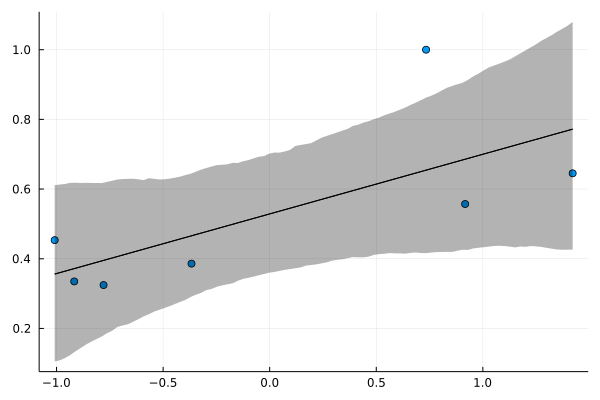

In [129]:
mass_seq = range(extrema(d.mass_std)...; length=100)
l = [
    @. r.a + r.b * mass_seq
    for r ∈ eachrow(m7_1)
]
l = vcat(l'...)
μ = mean.(eachcol(l))
ci = PI.(eachcol(l))
ci = vcat(ci'...)

scatter(d.mass_std, d.brain_std)
plot!(mass_seq, [μ μ]; fillrange=ci, c=:black, fillalpha=0.3)

In [130]:
# reimplemented the brand_plot function to check my results